# Лекция 9. Введение в итерационные методы, пространство Крылова и метод сопряжённых градиентов

## На прошлой лекции...
- Разреженные матрицы и форматы их хранения
- Прямые методы решения больших разреженных линейных систем
- Вектор Фидлера и сепаратор графа

## План на сегодня

Концепция **итерационных методов** для линейных систем:
- Метод Ричардсона и его сходимость
- Метод Чебышёва и его сходимость 
- Крыловские пространства
- Метод сопряжённых градиентов

## Итерационные методы

- Если мы хотим достичь сложности $\mathcal{O}(N)$ в решении разреженных линейных систем, то прямые методы нам не подходят.

- Если нам нужно решить частичную задачу на собственные значения, то полное спектральное разложение оказывается слишком дорогой операцией.

- Для обеих задач мы будем использовать итерационные методы, основанные на Крыловских подпространствах, которые рассматривают матрицу как **линейный оператор** для преобразования одного вектора в другой ("чёрный ящик"), а не как двумерный массив с числами.

## Матрица как "чёрный ящик"

- Сейчас рассмотрим альтернативный взгляд на то, что такое матрица: далее матрица – это линейный оператор, который действует на вектор, и результат этого действия можно вычислить за $\mathcal{O}(N)$ операций.

- **Единственная информация, которая нам доступна:** мы знаем о матрице только то, как умножать её на вектор!

- Можно ли решить линейную систему, используя только процедуру умножения матрицы на вектор?

- Конечно, мы можем умножить матрицу на столбцы единичной матрицы и восстановить матрицу, но это не то, что нам нужно.

## Метод Ричардсона (a.k.a метод простой итерации)

Простейшая идея приводит нас к **методу Ричардсона**.

$$Ax = f,$$
$$\tau  (Ax - f) = 0,$$
$$x - \tau (Ax - f) = x,$$
$$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
где $\tau > 0$ параметр метода, который надо выбрать так, чтобы метод сходился.

## Связь с обыкновенными дифференциальными уравнениями (ОДУ)

- Метод Ричардсона имеет глубокую связь с ОДУ.

- Рассмотрим задачу, зависящую от времени ($A=A^*>0$)

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

Тогда $y(t) \rightarrow A^{-1} f$ при $t \rightarrow \infty$, и **схема Эйлера** выглядит следующим образом

$$\frac{y_{k+1} - y_k}{\tau} = -A y_k + f,$$

что также приводит к методу Ричардсона

$$ y_{k+1} = y_k - \tau(Ay_k -f). $$

## Сходимость метода Ричардсона

- Пусть $x_*$ решение, введём вектор ошибки $e_k = x_{k} - x_*$, тогда  

$$ e_{k+1} = (I - \tau A) e_k, $$

поэтому если $\Vert I - \tau A \Vert < 1$ в некоторой норме, метод сходится. 

- Для случая симметричной положительно определённой матрицы всегда можно выбрать $\tau$ так, чтобы метод сошёлся.

- Поведение метода для несимметричной матрицы будет рассмотрено далее

## Выбор оптимального параметра

- Параметр $\tau$, который минимизирует $\|I - \tau A\|_2$ для $A = A^* > 0$, выражается следующим образом (получите это выражение!)

$$ \tau_\mathrm{opt} = \frac{2}{\lambda_{\min} + \lambda_{\max}}, $$

где $\lambda_{\min}$ – минимальное собственное значение, а $\lambda_{\max}$ – максимальное собственное значение матрицы $A$.

- Итак, чтобы найти оптимальный параметр нам нужно знать **границы спектра** матрицы $A$, и мы можем вычислить их с помощью **степенного метода**.

## Число обусловленности и скорость сходимости

- Даже с оптимальным выбором значения параметра $\tau$, ошибка на следующей итерации связана с ошибкой на текущей итерации следующим образом

$$\|e_{k+1}\|_2 \leq q \|e_k\|_2 , \quad\rightarrow \quad \|e_k\|_2 \leq q^{k} \|e_0\|_2,$$

где 

$$ q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1}, $$

$$\mathrm{cond}(A) = \frac{\lambda_{\max}}{\lambda_{\min}} \quad \text{для} \quad A=A^*>0$$

число обусловенности матрицы $A$.

- Далее покажем на примере сходимость метода Ричардсона...

Maximum eigenvalue = 3.682507065662361, minimum eigenvalue = 0.08101405277100546
Condition number = 45.45516413147909


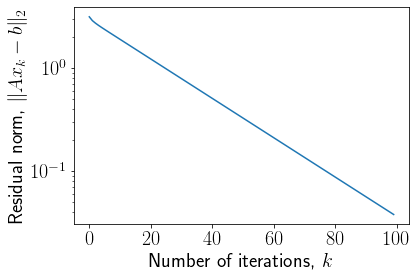

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 10
ex = np.ones(n);
A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_richardson = []
for i in range(niters):
    rr = A.dot(x) - rhs
    x = x - tau_opt * rr
    res_richardson.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.plot(res_richardson)
plt.yscale("log")
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print("Maximum eigenvalue = {}, minimum eigenvalue = {}".format(lam_max, lam_min))
print("Condition number = {}".format(lam_max.real / lam_min.real))

### Вывод о влиянии числа обусловленности на сходимость

- Для **плохо обусловленных** матриц норма вектора ошибки в методе Ричардсона убывает **очень** медленно.
- Это ещё одна причина, по которой число обусловленности очень важно: кроме того, что оно показывает ошибку при решении, оно также даёт оценку числа итераций для сходимости итерационных методов.
- Основной вопрос в разработке итерационных методов – как улучшить обусловленность матрицы?
- Ответом является использование <font color='red'> предобуславливателей (preconditioners) </font>. Эта тема будет рассмотрена далее в курсе.

### Рассмотрим несимметричную матрицу $A$

Возможные варианты поведения метода Ричардсона:
- сходимость
- расходимость
- почти стабильная траектория, то есть отсутствие сходимости, но и отсутствие существенного увеличения нормы вектора ошибки

###### Как мы можем определить поведение метода Ричардсона для несимметричной матрицы **до** запуска метода?

In [2]:
# B = np.random.randn(2, 2)
B = np.array([[1, 2], [-1, 0]])
#B = np.array([[0, 1], [-1, 0]])
print(B)
x_true = np.zeros(2)
f = B.dot(x_true)
eigvals = np.linalg.eigvals(B)
print("Spectrum of the matrix = {}".format(eigvals))

# Run Richardson iteration
x = np.array([0, -1])
tau = 1e-2
conv_x = [x]
r = B.dot(x) - f
conv_r = [np.linalg.norm(r)]
num_iter = 1000
for i in range(num_iter):
    x = x - tau * r
    conv_x.append(x)
    r = B.dot(x) - f
    conv_r.append(np.linalg.norm(r))

[[ 1  2]
 [-1  0]]
Spectrum of the matrix = [0.5+1.32287566j 0.5-1.32287566j]


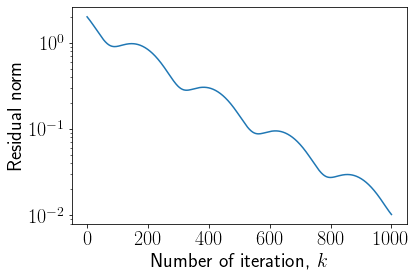

In [3]:
plt.plot(conv_r)
plt.yscale("log")
plt.xlabel("Number of iteration, $k$", fontsize=20)
plt.ylabel("Residual norm", fontsize=20)
plt.yticks(fontsize=20)
_ = plt.xticks(fontsize=20)

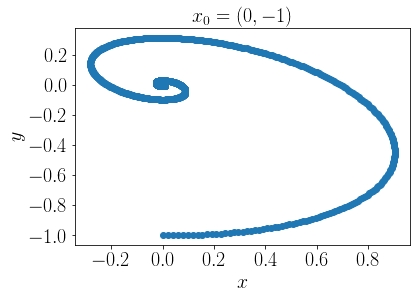

In [4]:
plt.scatter([x[0] for x in conv_x], [x[1] for x in conv_x])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
_ = plt.title("$x_0 = (0, -1)$", fontsize=20)

## Возможные улучшения метода простой итерации

- Наискорейший спуск
- Метод Чебышёва

## Улучшение 1: метод наискорейшего спуска

- Пусть мы можем изменять значения $\tau$ на каждой итерации, то есть 

$$ x_{k+1} = x_k - \tau_k (A x_k - f). $$

- Возможный выбор $\tau_k$ такой что, $\tau_k$ минимизирует нормы текущего вектора остатков, то есть

$$\tau_k = \arg\min_{\tau > 0} \|A(x_k - \tau (A x_k - f)) - f \|^2_2 $$

- Используя технику, аналогичную той, что использовалась для получения нормального уравнения, получим выражение для $\tau_k$

$$\tau_k = \frac{r_k^{\top}r_k}{r_k^{\top}Ar_k}, \quad r_k = Ax_k - f$$

- Такой метод называется **методом наискорейшего спуска**.

- Однако он сходится так же, как и метод Ричардсона.

## Улучшение 2: метод Чебышёва

- Другой метод нахождения $\tau_k$ заключается в рассмотрении следующего выражения

$$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

где $p(A)$ – **матричный полином** (простейшая матричная функция)  

$$ p(A) = (I - \tau_k A) \ldots (I - \tau_0 A), $$

и $p(0) = 1$.

## Оптимальный выбор шагов по времени

- Вектор ошибки можно записать в виде

$$e_{k+1} = p(A) e_0, $$

тогда 

$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$

где $p(0) = 1$ и $p(A)$ – **матричный полином**. 

- Для получения скорейшего уменьшения нормы вектора ошибки, нам нужно минимизировать

$$\Vert p(A) \Vert$$ 

по всем возможным полиномам $p(x)$ степени $k+1$, таких что $p(0)=1$. 
- Мы будем использовать спектральную норму $\|\cdot\|_2$.

##  Полиномы, наименее отклоняющиеся от 0

- Важный частный случай: $A = A^* > 0$.

- Тогда $A = U \Lambda U^*$, 

и 

$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_i |p(\lambda_i)| \overset{!}{\leq}
\max_{\lambda_\min \leq \lambda {\leq} \lambda_\max} |p(\lambda)|.$$

- Последнее неравенство является приближением: мы делаем <font color='red'> ключевое предположение </font> о не использовании распределения спектра между $\lambda_\min$ и $\lambda_\max$ для получения более быстрой сходимости.

- Таким образом, нам нужно найти такой полином заданной степени, что $p(0) = 1$ и отклонение от 0 является минимальным на отрезке $[\lambda_\min, \lambda_\max]$.

##  Масштабирование задачи с $[\lambda_\min, \lambda_\max]$ на $[-1, 1]$

- Мы можем сделать аффинное преобразование отрезка $[\lambda_\min, \lambda_\max]$ в отрезок $[-1, 1]$:

$$ \xi = \frac{{\lambda_\max + \lambda_\min - (\lambda_\min-\lambda_\max)x}}{2}, \quad x\in [-1, 1]. $$

- Теперь задача свелась к задаче поиска полинома, наименее отклоняющегося от 0 на отрезке $[-1, 1]$

## Точное решение: полиномы Чебышёва

- Точным решением этой задачи являются знаменитые **полиномы Чебышёва**, которые можно записать в виде

$$T_n(x) =  \cos (n \arccos x), \quad x \in [-1, 1]$$

## Что вам нужно знать о полиномах Чебышёва

1. Это полиномы!

2. Можно выразить $T_n$ из $T_{n-1}$ и $T_{n-2}$: 

$$T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x), \quad T_0(x)=1, \quad T_1(x)=x$$

3. $|T_n(x)| \leq 1$ на $x \in [-1, 1]$.

4. У них есть $n+1$ **точка альтернанса**, где максимальное абсолютное значение достигается (это необходимое и достаточное условие для **оптимальности**: об этом говорит теорема Чебышёва об альтернансе).

5. Корни записываются как 

$$n \arccos x_k = \frac{\pi}{2} + \pi k, \quad \rightarrow\quad x_k = \cos \frac{\pi(2k + 1)}{2n}, \; k = 0, \ldots,n-1$$

Мы можем их нарисовать!

Text(0.5, 1.0, 'Interval $x\\in[-1.1, 1.1]$')

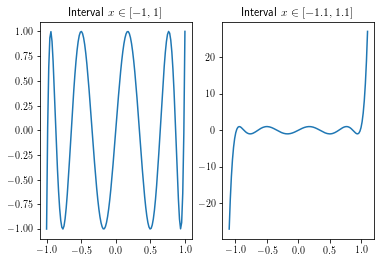

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x1 = np.linspace(-1, 1, 128)
x2 = np.linspace(-1.1, 1.1, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x1, p(x1))
ax1.set_title('Interval $x\in[-1, 1]$')
ax2.plot(x2, p(x2))
ax2.set_title('Interval $x\in[-1.1, 1.1]$')

## Сходимость метода Чебышёва

- Заметим, что $p(x) = (1-\tau_n x)\dots (1-\tau_0 x)$, поэтому корни $p(x)$ задаются как $1/\tau_i$ и нам осталось дополнительно отобразить их из $[-1,1]$ в $[\lambda_\min, \lambda_\max]$.

- Это даёт следующий результат

$$\tau_i = \frac{2}{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x_i}, \quad x_i = \cos \frac{\pi(2i + 1)}{2n}\quad i=0,\dots,n-1$$

- Сходимость теперь будет такой (без доказательства)

$$ e_{k+1} \leq C q^k e_0, \quad q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1}, $$

что лучше, чем у метода Ричардсона.

[3.6819647144817442, 3.6776278649924494, 3.6689646138641425, 3.655995831627603, 3.63875276121517, 3.617276942693781, 3.591620113191315, 3.5618440822573145, 3.528020582958373, 3.4902310990668894, 3.448566668759527, 3.403127665298269, 3.3540235552224402, 3.301372634634225, 3.2453017442129966, 3.1859459636450103, 3.1234482862046065, 3.057959274270888, 2.9896366966097645, 2.9186451482951723, 2.8451556541851266, 2.769345256907857, 2.691396590350612, 2.6114974396786246, 2.529840288944203, 2.446621857375787, 2.3620426254641, 2.276306351987082, 2.1896195831371505, 2.1021911549333288, 2.0142316901169854, 1.9259530907432025, 1.8375680276901643, 1.7492894283163813, 1.6613299635000383, 1.5739015352962162, 1.487214766446285, 1.4014784929692667, 1.3168992610575794, 1.2336808294891637, 1.152023678754742, 1.0721245280827543, 0.9941758615255097, 0.9183654642482408, 0.8448759701381943, 0.7738844218236021, 0.7055618441624789, 0.6400728322287605, 0.5775751547883563, 0.5182193742203696, 0.46214848379914164

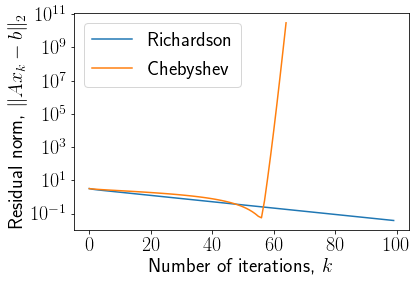

In [6]:
niters = 64
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb = [np.linalg.norm(r)]

print(taus)

for i in range(niters):
    x = x - 1.0 / taus[i] * r
    r = A.dot(x) - rhs
    res_cheb.append(np.linalg.norm(r))
    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

### Что сломалось в прекрасном методе Чебышёва?

[3.6819647144817442, 3.6776278649924494, 3.6689646138641425, 3.655995831627603, 3.63875276121517, 3.617276942693781, 3.591620113191315, 3.5618440822573145, 3.528020582958373, 3.4902310990668894, 3.448566668759527, 3.403127665298269, 3.3540235552224402, 3.301372634634225, 3.2453017442129966, 3.1859459636450103, 3.1234482862046065, 3.057959274270888, 2.9896366966097645, 2.9186451482951723, 2.8451556541851266, 2.769345256907857, 2.691396590350612, 2.6114974396786246, 2.529840288944203, 2.446621857375787, 2.3620426254641, 2.276306351987082, 2.1896195831371505, 2.1021911549333288, 2.0142316901169854, 1.9259530907432025, 1.8375680276901643, 1.7492894283163813, 1.6613299635000383, 1.5739015352962162, 1.487214766446285, 1.4014784929692667, 1.3168992610575794, 1.2336808294891637, 1.152023678754742, 1.0721245280827543, 0.9941758615255097, 0.9183654642482408, 0.8448759701381943, 0.7738844218236021, 0.7055618441624789, 0.6400728322287605, 0.5775751547883563, 0.5182193742203696, 0.46214848379914164

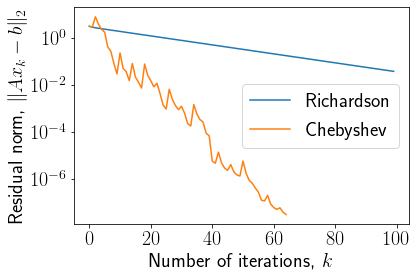

In [7]:
niters = 64
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb_even = [np.linalg.norm(r)]
print(taus)

# Implementation may be non-optimal if number of iterations is not power of two
def leb_shuffle_2n(n):
    if n == 1:
        return np.array([0,], dtype=int)
    else:
        prev = leb_shuffle_2n(n // 2)
        ans = np.zeros(n, dtype=int)
        ans[::2] = prev
        ans[1::2] = n - 1 - prev
        return ans

good_perm_even = leb_shuffle_2n(niters)
print(good_perm_even, len(good_perm_even))
# good_perm_even = np.random.permutation([i for i in range(niters)])

for i in range(niters):
    x = x - 1.0/taus[good_perm_even[i]] * r
    r = A.dot(x) - rhs
    res_cheb_even.append(np.linalg.norm(r))

    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb_even, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

- Перестановки корней полинома Чебышёва очень сильно влияют на сходимость метода (почему?)
- Об оптимальной перестановке можно прочитать в [этой статье](http://www.mathnet.ru/links/42ab1a270ad179d43359ef8fab53422c/zvmmf6870.pdf)

### Проект [Chebfun](http://www.chebfun.org/) 

- Проект с открытым исходным кодом для численных расчётов (с интерфейсом для [Python](https://github.com/chebpy/chebpy) и [Matlab](https://github.com/chebfun/chebfun))
- Основан на алгоритмах, работающих с кусочно-полиномиальными интерполяциями и Чебышёвскими полиномами
- Авторами проекта являются Nick Trefethen и его студент Zachary Battles, подробности см. в [этой статье](http://www.chebfun.org/publications/chebfun_paper.pdf)
- Chebfun нацелен на решение следующих задач
    - Аппроксимация
    - Квадратуры
    - ОДУ
    - Уравнения с частными производными
    - Поиск корней
    - Одномерная глобальная оптимизация

## Улучшения метода Чебышёва

- Мы сделали важное предположение о спектре: он содержится на отрезке (и нам нужны границы)

- Если спектр содержится в **двух отрезках** и мы знаем границы, также можно поставить задачу оптимизации для поиска оптимального полинома

## Если спектр матрицы лежит в нескольких отрезках

- Для случая двух отрезков оптимальными полиномами являются **[полиномы Золотарёва](https://www.encyclopediaofmath.org/index.php/Zolotarev_polynomials)** (выражаются через эллиптические функции). 
- Оригинальная работа опубликована в 1877, подробности см. [тут](http://gpntb.dlibrary.org/ru/nodes/4245-zolotarev-e-prilozhenie-ellipticheskih-funktsiy-k-voprosam-o-funktsiyah-naimenee-i-naibolee-otklonyayuschihsya-ot-nulya-spb-1877) 
- Для случая, когда интервалов больше двух, оптимальный полином может быть записан с помощью гиперэллиптических функций

## Как ещё можно ускорить метод Чебышёва?

- Реализация метода Чебышёва требует знания границ спектра.

- Метод хранит вектор $x_k$ и вычисляет новую поправку

$$r_k = A x_k - f.$$

- Оказывается, что если мы будем использовать больше векторов (не только $x_k$ и $r_k$), то мы можем избавиться от необходимости знать спектр и получим более быструю сходимость!

## Главная идея: Крыловские пространства

- Метод Чебышёва даёт аппроксимацию вида

$$x_{k+1} = x_0 + p(A) r_0,$$

то есть $x_{k+1}$ лежит в Крыловском пространстве.
- Крыловское пространство определяется для матрицы $A$ следующим образом

$$ \mathcal{K}_k(A, r_0) = \mathrm{Span}(r_0, Ar_0, A^2 r_0, \ldots, A^{k-1}r_0 ) $$

- Наиболее естественный подход теперь – это искать вектор в этом пространстве, который минимизирует норму некоторого вектора

## Идея Крыловских методов

Идея заключается в минимизации заданного функционала:
- Энергетическая норма вектора ошибки для систем с эрмитовой положительно определённой матрицей (метод сопряжённых градиентов).
- Норма вектора остатков для систем с матрицами общего вида (методы minres и GMRES).
- Отношение Релея для частичных задач на собстенные значения (метод Ланцоша).

Для того чтобы сделать метод практичным нужно следующее
1. Ортогонализовать векторы $A^i r_0$ Крыловского подпространства для устойчивости (процесс Ланцоша).
2. Получить рекуррентные формулы для уменьшения сложности.

## Решение линейных систем и минимизация функционалов

- Вместо решения линейной системы, мы можем минимизировать норму вектора остатков:

$$R(x) = \Vert A x - f \Vert^2_2.$$

- Условие оптимальности первого порядка $\nabla R(x) = 0$ даёт

$$A^* A x = A^* f,$$

таким образом число обусловленности возвелось в квадрат, поэтому явная минимизация нормы остатков с помощью стандартных методов оптимизации используется редко.

- Для случая симметричной положительно определённой матрицы есть более простой функционал.

## Функционал энергии

Пусть $A = A^* > 0$, тогда следующий функционал

$$\Phi(x) = (Ax, x)  - 2(f, x)$$

называется **функционалом энергии**.

### Свойства функционала энергии

- Строго выпуклый (проверьте!)

$$ \Phi(\alpha x + (1 - \alpha)y) < \alpha \Phi(x) + (1 - \alpha) \Phi(y)$$

- Так как он строго выпуклый, то у него есть единственный локальный минимум, который также является глобальным

- Глобальный минимум $x_*$ удовлетворяет равенству

$$A x_* = f.$$

- В самом деле, 

$$\nabla \Phi = 2(Ax - f).$$ 

и условие оптимальности первого порядка $\nabla \Phi (x_*) = 0$ даёт

$$A x_* = f.$$

## Аппроксимация решения на подпространстве

- Пусть дано линейное $M$-мерное подпространство с базисными векторами $\{y_1, \dots, y_M\}$, мы хотим найти приближённое решение в этом базисе, то есть 

$$A x \approx f, \quad x = x_0 +  \sum_{k=1}^M c_k y_k,$$

где $c$ – вектор коэффициентов.

- В случае симметричной положительно определённой матрицы нам нужно минимизировать

$$(Ax, x) - 2(f, x)$$ 

при условии 

$$x = x_0 + Y c,$$

где $Y=[y_1,\dots,y_M]$ матрица размера $n \times M$ и вектор $c$ имеет размерность $M$.

- Используя представление для $x$, получаем следующую задачу минимизации на вектор $c$:

$$\widehat{\Phi}(c) = (A Y c, Y c) + 2 (Y^*Ax_0, c) - 2(f, Y c) = (Y^* A Y c, c) - 2(Y^* (f - Ax_0), c).$$

- Отметим, что это тот же самый функционал энергии, но для **Галёркинской проекции** матрицы $A$:

$$Y^* A Y c = Y^* (f - Ax_0) = Y^* r_0,$$

что является линейной системой размера $M \times M$ с симметричной положительно определённой матрицей, если $Y$ имеет полный ранг.

- Но как выбрать $Y$?

## Выбор подпространства

- В Крыловском подпространстве мы генерируем всё подпространство из единственного вектора $r_0 = f - Ax_0$:

$$y_0\equiv k_0 = r_0, \quad y_1\equiv k_1 = A r_0, \quad y_2\equiv k_2 = A^2 r_0, \ldots, \quad y_{M-1}\equiv k_{M-1} = A^{M-1} r_0.$$

- Это даёт **Крыловское подпространство** порядка $M$

$$\mathcal{K}_M(A, r_0) = \mathrm{Span}(r_0, Ar_0, \ldots, A^{M-1} r_0).$$

- Оригинальная работа, в которой вводятся такие подпространства "О численном решении уравнения, которым в технических вопросах определяются частоты малых колебаний материальных систем",  А. Н. Крылов, 1931, доступна [тут](http://www.mathnet.ru/links/a2431bc65c0764da9a1ae95c73f741f6/im5215.pdf)

## Решение $x_*$ лежит в Крыловском подпространстве $x_* \in \mathcal{K}_n(A, f)$

- По теореме [Гамильтона-Кэли](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%93%D0%B0%D0%BC%D0%B8%D0%BB%D1%8C%D1%82%D0%BE%D0%BD%D0%B0_%E2%80%94_%D0%9A%D1%8D%D0%BB%D0%B8): $p(A) = 0$, где $p(\lambda) = \det(A - \lambda I)$
- $p(A)f = A^nf + a_1A^{n-1}f + \ldots + a_{n-1}Af + a_n f = 0$
- $A^{-1}p(A)f = A^{n-1}f + a_1A^{n-2}f + \ldots + a_{n-1}f + a_nA^{-1}f = 0$
- $x_* = A^{-1}f = -\frac{1}{a_n}(A^{n-1}f + a_1A^{n-2}f + \ldots + a_{n-1}f)$
- Таким образом, $x_* \in \mathcal{K}_n(A, f)$

## Плохая обусловленность естественного базиса

Естественный базис в Крыловском подпространстве очень **плохо обусловлен**, поскольку 

$$k_i = A^i r_0 \rightarrow \lambda_\max^i v,$$

где $v$ собственный вектор, соответствующий максимальному собственному значению $A$, то есть $k_i$ становятся всё более и более коллинеарными для больших $i$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spsp
%matplotlib inline

n = 100
ex = np.ones(n);
# A = spsp.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr') 
A = np.random.randn(n, n)
f = np.ones(n)
x0 = np.random.randn(n)

subspace_order = 10
krylov_vectors = np.zeros((n, subspace_order))
krylov_vectors[:, 0] = f - A.dot(x0)
for i in range(1, subspace_order):
    krylov_vectors[:, i] = A.dot(krylov_vectors[:, i-1])
    
s = np.linalg.svd(krylov_vectors, compute_uv=False)
print("Condition number = {}".format(s.max() / s.min()))

Condition number = 850538169.9119898


### Решение: получить ортогональный базис в Крыловском подпространстве

## Хороший базис в Крыловском подпространстве

- Для повышения устойчивости мы сначала ортогонализуем векторы из Крыловского подпространства, используя процесс Грама-Шмидта (или QR разложение)

$$K_j = \begin{bmatrix} r_0 & Ar_0 & A^2 r_0 & \ldots & A^{j-1} r_0\end{bmatrix} = Q_j R_j. $$

- После чего решение приближается как $$x \approx x_0 + Q_j c.$$ 


## Короткий путь к соотношению Арнольди

**Утверждение.** Матрица Крыловских векторов $K_j$ удовлетворяет важному рекуррентному соотношению (которое называется **соотношение Арнольди**)

$$A Q_j = Q_j H_j + h_{j, j-1} q_j e^{\top}_{j-1},$$

где $H_j$ – верхне-гессенбергова матрица, а  $Q_{j+1} = [q_0,\dots,q_j]$ имеет ортонормированные столбцы, которые образуют пространство $K_{j+1}$.

- Давайте докажем его (для простоты рассмотрим $j = 3$):

$$A \begin{bmatrix} k_0 & k_1 & k_2 \end{bmatrix} = \begin{bmatrix} k_1 & k_2 & k_3 \end{bmatrix} = \begin{bmatrix} k_0 & k_1 & k_2 \end{bmatrix} \begin{bmatrix} 0 & 0 & \alpha_0 \\ 1 & 0  & \alpha_1 \\ 0 & 1  & \alpha_2 \\ \end{bmatrix} + \begin{bmatrix} 0 & 0 & k_3  - \alpha_0 k_0 - \alpha_1 k_1 - \alpha_2 k_2 \end{bmatrix}, $$
 
где $\alpha_s$ будут выбраны позднее. 

- Обозначим $\widehat{k}_3 = k_3  - \alpha_0 k_0 - \alpha_1 k_1 - \alpha_2 k_2$.
 
- В матричной форме,
 
 $$A K_3 = K_3 Z + \widehat k_3 e^{\top}_2,$$
 
 где $e_2$ – последний столбец единичной матрицы.
 
- Пусть QR разложение матрицы $K_3$ имеет вид

$$K_3 = Q_3 R_3.$$

Тогда
 
 $$A Q_3 R_3 = Q_3 R_3 Z + \widehat{k}_3 e^{\top}_2,$$
 
 $$ A Q_3 = Q_3 R_3 Z R_3^{-1} + \widehat{k}_3 e^{\top}_2 R_3^{-1}.$$


- Заметим, что

$$e^{\top}_2 R_3^{-1} = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \end{bmatrix}  = \gamma e^{\top}_2,$$
 
 и
 
 $$R_3 Z R_3^{-1} = \begin{bmatrix} * & * & * \\* & * & * \\  0 & * & * \\ \end{bmatrix},$$      

в общем случае она будет искомой матрицей $H$ и будет иметь верхне-гессенбергову форму, то есть матрица имеет вид

$$H_{ij} = 0, \quad \mbox{если } i > j + 1.$$

## (Почти) соотношение Арнольди

- Пусть $Q_j$ ортогональный базис в Крыловском подпространстве, тогда мы получили почти соотношение Арнольди

$$A Q_j = Q_j H_j +  \gamma\widehat{k}_j e^{\top}_{j-1},$$

где $H_j$ верхне-гессенбергова форма и 

$$\widehat{k}_j = k_j - \sum_{s=0}^{j-1} \alpha_s k_s.$$

- Мы выберем $\alpha_s$ таким образом, чтобы

$$Q^*_j \widehat{k}_j = 0.$$

- Тогда $\widehat{k}_j = h_{j, j-1} q_j,$ где $q_j$ последний столбец в матрице $Q_{j+1}$.

## Соотношение Арнольди: итоговое выражение

Получили рекуррентное соотношение

$$A Q_j = Q_j H_j + h_{j, j-1} q_j e^{\top}_{j-1}.$$

- Это ключевая формула для эффективной генерации векторов из Крыловских подпространств.

- Для несимметричного случая это выражение совпадает с модифицированным методом Грама-Шмидта.

- Для симметричного случая у нас будет более простая форма (процесс Ланцоша).

## Процесс Ланцоша

- Если $A = A^*$, тогда

$$Q^*_j A Q_j = H_j, $$

таким образом $H_j$ эрмитова, и следовательно трёхдиагональна, $H_j = T_j$.

- Это даёт нам короткое рекуррентное выражение для генерации векторов Арнольди $q_j$ без **полной** ортогонализации.

## Процесс Ланцоша (2)

$$ A Q_j = Q_j T_j + t_{j, j-1} q_j e^{\top}_{j-1}.$$


- Для получения вектора $q_j$ нам нужно вычислить только последний столбец

$$t_{j, j-1} q_j = (A Q_j - Q_j T_j) e_{j-1} = A q_{j-1} - t_{j-1, j-1} q_{j-1} - t_{j-2, j-1} q_{j-2}. $$

- Коэффициенты $\alpha_j = t_{j-1, j-1}$ и $\beta_j = t_{j-2, j-1}$ могут быть восстановлены из условий ортогональности

$$(q_j, q_{j-1}) = 0, \quad (q_j, q_{j-2}) = 0$$

- **Все остальные ограничения на ортогональность будут выполнены автоматически!!**

- И нам нужно хранить только два вектора, чтобы получить новый вектор.

## От явного процесса Ланцоша к методу сопряжённых градиентов

- Теперь мы можем получить из рекуррентных формул метода Ланцоша знаменитый **метод сопряжённых градиентов**.

- Для матрицы $A = A^* > 0$

$$A Q_j = Q_j T_j + T_{j, j-1} q_j.$$

- Вспомним, что при минимизации функционала энергии в базисе $Y$ мы получили линейную систему 

$$Y^* A Y c = Y^* f.$$

- Здесь $Y = Q_j$, поэтому приближённое решение $Ax \approx f$ при условии $x_j = x_0 + Q_j c_j$ может быть получено из решения линейной системы меньшей размерности

$$Q^*_j A Q_j c_j = T_j c_j = Q^*_j r_0 .$$

- Так как $r_0$ образует Крыловское подпространство первого порядка, то

$$Q^*_j r_0  = \Vert r_0 \Vert_2^2 e_0 = \gamma e_0.$$

- У нас есть трёхдиагональная система уравнений на $c$:

$$T_j c_j = \gamma e_0$$

и $x_j = Q_j c_j$.

- Мы можем остановится на этом месте, но вместо решения трёхдиагональной системы мы можем получить короткие рекуррентные формулы  для каждой итерации.

- Так как $A$ положительно определена, $T_j$ также положительно определена и имеет LU разложение

- $T_j = L_j U_j$, где $L_j$ бидиагональная матрица с единицами на диагонали, $U_j$ верхне-бидиагональная матрица.

- Нам нужно определить одну поддиагональ в $L$ (с элементами $c_1, \ldots, c_{j-1}$), главную диагональ $U_j$ (с элементами $d_0, \ldots, d_{j-1}$ и наддиагональ в $U_j$ (с элементами $b_1, \ldots, b_{j-1}$).

- Для них выполнены удобные рекуррентные соотношения:

$$c_i = b_i/d_{i-1}, \quad d_i = \begin{cases} a_1, & \mbox{если } i = 0, \\
a_i - c_i b_i, & \mbox{если } i > 0. \end{cases}$$

- Для решения выполнено

$$x_j = Q_j T^{-1}_j \gamma e_0  = \gamma Q_j (L_j U_j)^{-1} e_0  = \gamma Q_j U^{-1}_j L^{-1}_j e_0.$$

- Введём две новых величины:  

$$P_j = Q_j U^{-1}_j, \quad z_j = \gamma L^{-1}_j e_0.$$

- Теперь у нас есть следующее выражение для $x_j$:

$$ x_j = P_j z_j$$

- Из-за рекуррентных соотношений у нас есть

$$P_j = \begin{bmatrix} P_{j-1} & p_j \end{bmatrix}, $$

и 

$$z_j = \begin{bmatrix} z_{j-1} \\ \xi_{j} \end{bmatrix}.$$

- Для $p_j$ и $\xi_j$ у нас есть короткие рекуррентные соотношения (из-за бидиагональной структуры)

$$p_j = \frac{1}{d_j}\left(q_j - b_j p_{j-1} \right), \quad \xi_j = -c_j \xi_{j-1}.$$

- Таким образом, мы пришли к коротким рекуррентным соотношениям для $x_j$:

$$x_j = P_j z_j = P_{j-1} z_{j-1} + \xi_j p_j = x_{j-1} + \xi_j p_j.$$

и $q_j$ ищутся из соотношения Ланцоша (см слайды ранее).

- Этот метод для решения линейных систем называется **прямой метод Ланцоша**. Он тесно связан с методом сопряжённых градиентов.

## Прямой метод Ланцоша

- У нас есть прямой метод Ланцоша, в котором мы храним

$$p_{j-1}, q_j, x_{j-1}$$ 

для получения новой оценки $x_j$.

- Основная проблема с $q_j$: у нас есть трёхчленное рекуррентное соотношение, но в неточной арифметике ортогональность может теряться, что ведёт к ошибкам при вычислении.

- Далее короткая демонстрация такого поведения

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse as spsp
from scipy.sparse import csc_matrix

n = 128
ex = np.ones(n);
A = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)

nit = 65
q1 = rhs/np.linalg.norm(rhs)
q2 = A.dot(q1)
q2 = q2 - np.dot(q2, q1)*q1
q2 = q2/np.linalg.norm(q2)
qall = [q1, q2]
for i in range(nit):
    qnew = A.dot(qall[-1])
    qnew = qnew - np.dot(qnew, qall[-1])*qall[-1]
    qnew = qnew/np.linalg.norm(qnew)
    qnew = qnew - np.dot(qnew, qall[-2])*qall[-2]
    qnew = qnew/np.linalg.norm(qnew)
    qall.append(qnew)
qall_mat = np.vstack(qall).T
print(np.linalg.norm(qall_mat.T.dot(qall_mat) - np.eye(qall_mat.shape[1])))

1.7739805413136174


## Метод сопряжённых градиентов (CG)

- Вместо использования вектора $q_j$ (последнего вектора из модифицирвоанного метода Грама-Шмидта), удобнее работать с вектором остатков

$$r_j = f - A x_j.$$

- Итоговые рекуррентные формулы имеют вид

$$x_j = x_{j-1} + \alpha_{j-1} p_{j-1}$$

$$r_j = r_{j-1} - \alpha_{j-1}  A p_{j-1}$$

$$p_j = r_j + \beta_j p_{j-1}.$$

- Отсюда следует название сопряжённых градиентов: к градиентам $r_j$ мы прибавляем **сопряжённые направления** $p_j$.

- Выполнена ортогональность остатков (проверьте!):

$$(r_i, r_j) = 0, \quad i \ne j$$

и **A-ортогональность** сопряжённых направлений:

$$ (A p_i, p_j) = 0,$$

которая может быть проверена по определению (проверьте!).

- Уравнения на $\alpha_j$ и $\beta_j$ могут быть теперь определены из этих двух свойств.

## Итоговые формулы для метода сопряжённых градиентов

- Мы знаем, что  $(r_{j}, r_{j-1}) = 0 = (r_{j-1} - \alpha_{j-1} A r_{j-1}, r_{j-1})$, 

тогда

$$\alpha_{j-1} = \frac{(r_{j-1}, r_{j-1})}{(A r_{j-1}, r_{j-1})}.$$

- Таким же способом, получим

$$\beta_{j-1} = \frac{(r_j, r_j)}{(r_{j-1}, r_{j-1})}.$$

- Вспомним, что

$x_j = x_{j-1} + \alpha_{j-1} p_{j-1}$

$r_j = r_{j-1} - \alpha_{j-1}  A p_{j-1}$

$p_j = r_j + \beta_j p_{j-1}$.

- Требуется только одно умножение матрицы на вектор.


## Как мы получили метод сопряжённых градиентов: обзор

- Хотим найти вектор $x_*$ в Крыловском подпространстве
- Но естественный базис плохо обусловлен, поэтому нам нужна ортогонализация
- Вывести рекуррентные соотношения для последовательной ортогонализации векторов из базиса в Крыловско подпространстве
    - процесс Арнольди для несимметричных матриц
    - процесс Ланцоша для симметричных матриц
- Правильное переписывание этих формул даёт короткие рекуррентные соотношения

## Свойства метода сопряжённых градиентов

- Нужно хранить 3 вектора.

- Поскольку он генерирует $A$-ортогональную последовательность $p_1, \ldots, p_N$, после $n$ шагов он должен остановиться

- На практике это свойство не выполняется в неточной арифметике, поэтому после того, как в 1952 году Хестенс и Штифель изобрели этот метод, он был назван **неустойчивым**.

- На самом деле это замечательный итерационный метод!

## $A$-оптимальность


- Функционал энергии может быть записан в виде

$$(Ax, x) - 2(f, x) = (A (x - x_*), (x - x_*)) - (Ax _*, x_*),$$

где $A x_* = f$. 

- С точностью до постоянного множителя

$$ (A(x - x_*), (x -x_*)) = \Vert x - x_* \Vert^2_A,$$

что является **A-нормой** вектора ошибки.


## Сходимость

- CG вычисляет $x_k$, который минимизирует функционал энергии на Крыловском подпространстве, то есть $x_k = p(A)f$, где $p$ – полином степени $k+1$, поэтому

$$\Vert x_k - x_* \Vert_A  =  \inf\limits_{p} \Vert \left(p(A) - A^{-1}\right) f \Vert_A. $$

- Используя спектральное разложение матрицы $A$ получим

$$A = U \Lambda U^*, \quad  g = U^* f,$$ 

и

$$\Vert x - x_* \Vert^2_A = \displaystyle{\inf_p} \Vert \left(p(\Lambda) - \Lambda^{-1}\right) g \Vert_\Lambda^2 = \displaystyle{\inf_p}
\displaystyle{\sum_{i=1}^n} \frac{(\lambda_i p(\lambda_i) - 1)^2 g^2_i}{\lambda_i} = \displaystyle{\inf_{q, q(0) = 1}} \displaystyle{\sum_{i=1}^n} \frac{q(\lambda_i)^2 g^2_i}{\lambda_i}
$$

- Выбор оптимального $q$ зависит от распределения собственных значений.



## Абсолютная и относительная ошибка

- Имеет место следующее выражение

$$\Vert x - x_* \Vert^2_A \leq \sum_{i=1}^n \frac{g^2_i}{\lambda_i} \inf_{q, q(0)=1} \max_{j} q({\lambda_j})^2$$

- Первый множитель

$$\sum_{i=1}^n \frac{g^2_i}{\lambda_i} = (A^{-1} f, f) = \Vert x_* \Vert^2_A.$$

- И мы получили оценку на относительную ошибку

$$\frac{\Vert x - x_* \Vert_A }{\Vert x_* \Vert_A} \leq \inf_{q, q(0)=1} \max_{j} |q({\lambda_j})|.$$

- Таким образом, если матрица имеет только 2 различных собственных значения, тогда существует полином степени 2 такой что $q({\lambda_1}) = q({\lambda_2}) = 0$, и в этом случае CG сходится за 2 итерации.

<font color='red'>

- Если собственные значения кластеризованы и имеется $l$ выбросов, тогда после первых $\mathcal{O}(l)$ итераций CG сойдётся как будто этих выбросов не было (следовательно, эффективное число обусловленности меньше).
    
- Интуитивное объяснение этого факта в том, что после $\mathcal{O}(l)$ итераций полином имеет степень больше чем $l$ и таким образом зануляет $l$ выбросов.
</font>


- Давайте найдём другую полезную оценку сходимости.
- Так как

$$
\inf_{q, q(0)=1} \max_{j} |q({\lambda_j})| \leq \inf_{q, q(0)=1} \max_{\lambda\in[\lambda_\min,\lambda_\max]} |q({\lambda})|,
$$

то используя результат, используемый в методе Чебышёва, получим такую же скорость сходимости:

$$\frac{\Vert x_k - x_* \Vert_A }{\Vert x_* \Vert_A} \leq \gamma \left( \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1}\right)^k.$$

## Остановка за конечное число шагов & кластеризация спектра

1. Если $A$ имеет $m$ различных собственных значений, CG сойдётся за $m$ итераций (покажите!).
2. Если $A$ имеет $m$ "кластеров" собственных значений, CG будет сходится по очереди учитывая каждый кластер.

#### В результате: сходимость лучше, чем у метода Чебышёва, но чуть более высокая стоимость одной итерации

## Резюме про CG

CG – это метод, которым нужно решать линейные системы с 

симметричными положительно определёнными матрицами:

1. Требует $\mathcal{O}(n)$ памяти
2. Корень из числа обусловленности в оценке сходимости
3. Автоматическое использование выбросов и кластеров собственных значений
4. Свойство $A$-оптимальности

## Нелинейный метод сопряжённых градиентов

- CG минимизирует функционал энергии, который является квадратичным по $x$
- Формулы CG были отправной точкой для разработки методов минимизации произвольной выпуклой функции
- Наиболее популярные расширения метода сопряжённых градиентов (также известный как нелинейный метод сопряжённых градиентов): 
    - [метод Hestenes'a-Stiefel'a](https://www.fing.edu.uy/inco/cursos/numerico/aln/hes_stief1952.pdf)
    - [метод Polak'a-Ribiere'a](http://www.numdam.org/article/M2AN_1969__3_1_35_0.pdf) - оригинальная работа на французском :)
    - [метод Fletcher'a–Reeves'a](https://watermark.silverchair.com/070149.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAkMwggI_BgkqhkiG9w0BBwagggIwMIICLAIBADCCAiUGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMiWM0crDA8bZ0Fj5HAgEQgIIB9tIM8xbxhkhniJQifurRLHIaOcnos9gvgBj8Lkc34eBUtUg4oYzjusGP_FZiHfpBoRnM409FFCs-Y5xxomumnGRQ8UIZJe7CPSmaCcSklAdwHN3Ja-fHfALctP68U3mGGeR11P8vlESoS7HZhZEmVhFb5m7jPk1ENZKLlq9CnVTz2n2bI3HPYCfDIo8ywd8RWo5gw6EwYnZ46l1ExES8AHMqlklpgzdupLhL6HxTzBEHd_qY4B2FjK4m4MpvdaX5imEnOD6YCwZMNC_qLzUdPxumcXl4oTRDyJp1kg_6PcGi98hE10InOp4aHJeIjl5FPJnuEFEBcv28asOq4vngp6N5d-4y1fpeoxcAe4d857TeLtQnGD6LlCAL_3Mh0lQ8iYLLfjw4b_V2jHEuSxKH3BalLPMS5KF2nGqqrzfbDs8x9jW-OlkeL_x68Zidv0rTHqTd0ww3kvSINDjgw6owPMLK9KxEWP5T-4dnu_kn-NXR1W0s52kUHFD1U9AWs5Zzh4RTVOXsdjGQciWzOO-XieLn8Aju-0P8mVEGjUDOjLDZtuPYM-Ep_Z9lp8TNDCi2lB5IQFbKVpBFaAItDDyVUvKNPfBovmKlnPRFLZYjLbgocnU3tcy0YB8RZegC56Gxn7g_WkphptCVPm7IDeCE9l5gcFafuY0)

## Несимметричные системы и обобщённый метод минимальных невязок (GMRES) [(Y. Saad, M. Schultz, 1986)](https://epubs.siam.org/doi/10.1137/0907058)

- До этого мы обсуждали симметричные положительно определённые системы. Что будет если $A$ несимметричная?

- Мы по-прежнему можем ортогонализовать Крыловское подпространство используя процесс Арнольди и получить

$$A Q_j = Q_j H_j + h_{j,j-1}q_j e^{\top}_{j-1}.$$

- Перепишем последнее неравенство в виде

$$ A Q_j = Q_j H_j + h_{j,j-1}q_j e^{\top}_{j-1} = Q_{j+1} \widetilde H_j, \quad \widetilde H_j = 
\begin{bmatrix} h_{0,0} & h_{0,1} & \dots & h_{0,j-2} & h_{0,j-1} \\ h_{1,0} & h_{1,1} & \dots & h_{1,j-2} & h_{1,j-1} \\ 0& h_{2,2} &  \dots & h_{2,j-2} & h_{2,j-1} \\
0& 0 & \ddots & \vdots & \vdots  \\
0& 0 &  & h_{j,j-1} & h_{j-1,j-1} \\ 0& 0 & \dots & 0 & h_{j,j-1}\end{bmatrix}$$

- Тогда если нам нужно минимизировать норму вектора остатков на Крыловском подпространстве, то

$$x_j = x_0 + Q_j c_j $$

и $x_j$ должен быть выбран следующим образом 

$$ \Vert A x_j - f \Vert_2 =  \Vert A Q_j c_j - r_0 \Vert_2 \rightarrow \min_{c_j}.$$

- Используя процесс Арнольди, получим, что

$$ \Vert Q_{j+1} \widetilde H_j c_j -  r_0 \Vert_2 \rightarrow \min_{c_j}.$$

- Используя унитарную инвариантность

$$ \Vert \widetilde H_j c_j - \gamma e_0 \Vert_2 \rightarrow \min_{c_j},$$

где мы используем факт, что $Q^*_{j+1} r_0 = \gamma e_0.$

- Получили линейную задачу наименьших квадратов с $(j+1)$ уравнением и $j$ неизвестными.

- Матрица также верхне-гессенбергова, поэтому её QR разложение можно вычислить очень быстро.

- Это позволяет вычислить $c_j$. Метод называется **GMRES** (обобщённых минимальных невязок)

## Главное про GMRES

- Минимизирует норму остатков напрямую
- Без использования нормальных уравнений
- Требуемая память растёт с числом итераций как $\mathcal{O}(j^2)$, поэтому обычно используются **рестарты** (запуск GMRES с нового начального приближения).

<Figure size 720x360 with 0 Axes>

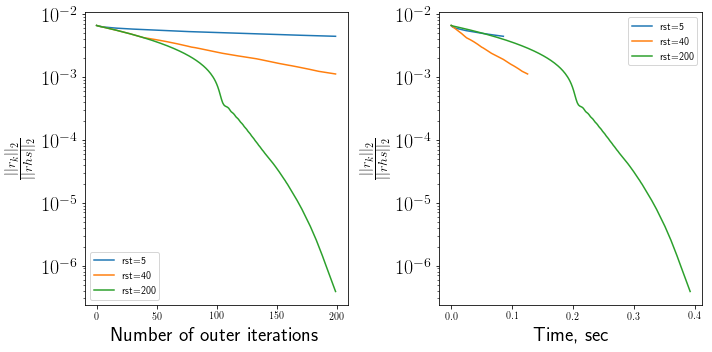

In [8]:
import scipy.sparse.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline
n = 150
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)

plt.figure(figsize=(10, 5))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for restart in [5, 40, 200]:
    hist = []
    def callback(rk):
        hist.append(np.linalg.norm(rk) / np.linalg.norm(rhs))
    st = time.time()
    sol = la.gmres(A, rhs, x0=np.zeros(n*n), maxiter=200, restart=restart, callback=callback, tol=1e-16)
    current_time = time.time() - st
    ax1.semilogy(np.array(hist), label='rst={}'.format(restart))
    ax2.semilogy([current_time * i / len(hist) for i in range(len(hist))], np.array(hist), label='rst={}'.format(restart))
    

ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Number of outer iterations", fontsize=20)
ax2.set_xlabel("Time, sec", fontsize=20)
ax1.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
ax2.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
plt.sca(ax1)
plt.yticks(fontsize=20)
plt.sca(ax2)
plt.yticks(fontsize=20)
f.tight_layout()

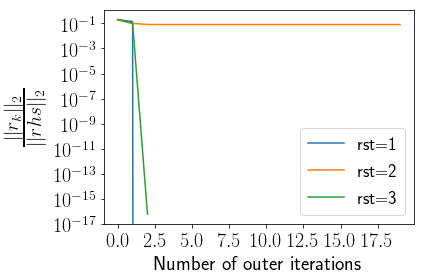

In [49]:
import scipy.sparse.linalg as la
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Example from http://www.caam.rice.edu/~embree/39961.pdf

A = np.array([[1, 1, 1],
              [0, 1, 3],
              [0, 0, 1]]
            )
rhs = np.array([2, -4, 1])
x0 = np.zeros(3)

for restart in [1, 2, 3]:
    hist = []
    def callback(rk):
        hist.append(np.linalg.norm(rk)/np.linalg.norm(rhs))
    _ = la.gmres(A, rhs, x0=x0, maxiter=20, restart=restart, callback=callback)
    plt.semilogy(np.array(hist), label='rst={}'.format(restart))
plt.legend(fontsize=18)
plt.xlabel("Number of outer iterations", fontsize=20)
plt.ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

## Главное
- Итерационные методы - общая концепция
- Метод Ричардсона и Чебышёва
- Подпространство Крылова
- Соотношение Арнольди
- Метод сопряжённых градиентов (CG) и его сходимость
- Обобщённый метод минимальных невязок (GMRES)